# Lab: ML-based Sentiment Classification

## Introduction

In this lab, we will explore the task of sentiment classification using machine learning (ML). We will be using the Yelp review dataset.

### The Dataset

The Yelp review dataset contains reviews along with a numeric score for each review. Each score ranges from 1 to 5, where 1 represents a very poor review and 5 represents an excellent one.

### Task Details

We'll be addressing two tasks in this session:

1. **3-class sentiment analysis:** We'll transform the score into a sentiment, where scores 1-2 map to negative, 3 maps to neutral, and 4-5 map to positive. For this task, we'll balance the training set using random undersampling to ensure each class has an equal presence.

2. **5-class sentiment analysis:** Here, each unique score will represent its own class, resulting in a 5-class problem.

In both tasks, we will employ a linear Support Vector Machine (SVM) with a one-versus-all multi-class handling strategy. The SVM algorithm is renowned for its effectiveness in high-dimensional spaces, making it suitable for text classification problems.

### Feature Engineering

Feature engineering is the process of designing and developing the representation of instances for a given task. This process determines the potential patterns that can be identified during learning.

We differentiate between two types of features:

1. **Standard features:** These are derived from more or less general linguistic phenomena and can aid in various tasks.
2. **Specific features:** These are tailored for specific tasks and usually require expert knowledge about the task.

For our task, we will employ a combination of both standard and specific features.

**Standard Content Features**

- _Token n-grams:_ These are sequences of n words or characters within a text. They allow us to capture local context.

- _Target class features:_ These are the keywords or phrases which are typically associated with a particular sentiment. For instance, words like 'terrible' or 'disappointing' are usually associated with negative sentiment.

**Standard Style Features**

- _Part of Speech (POS) and phrase n-grams:_ They encapsulate grammatical patterns that might be indicative of sentiment.

- _Stylometric features:_ These include characteristics like sentence length, use of punctuation, capitalization, etc., which may offer clues about the sentiment.

```{figure} figs/8.png
---
width: 70%
name: fig-ling-phenomena
---
Some General Linguistic Phenomena
```

**Specific Features**

- _Local sentiment:_ Sentiment scores assigned to sentences or phrases within the text, using sentiment lexicons.

- _Discourse relations:_ Sentiment polarity can be influenced by discourse markers. For example, the word 'but' often introduces a contrast in sentiment.

- _Flow patterns:_ These refer to the sequence of positive, negative, and neutral sentiments in the review. For example, a pattern of 'positive-negative-positive' might indicate a more complex sentiment structure.

During the lab session, we will walk you through the process of extracting these features from the text data and training our SVM model for sentiment classification. By the end of this session, you should have a clear understanding of how to design, implement, and evaluate a sentiment classification task using a machine learning approach.

Let's begin!


## Loading the Dataset

We'll start by importing the libraries we'll be using in this lab.


In [ ]:
%pip install datasets imblearn

In [1]:
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


/home/yjlee/.cache/pypoetry/virtualenvs/lecture-_dERj_9R-py3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We'll now load the dataset using the `datasets` module from the Hugging Face library. We'll be using the `argilla/tripadvisor-hotel-reviews` dataset, which contains hotel reviews along with their corresponding scores.


In [9]:
dataset = load_dataset("yelp_review_full")

# The dataset is returned as a 'DatasetDict', let's convert it to a pandas DataFrame
df = pd.DataFrame(dataset["train"])


Dataset yelp_review_full downloaded and prepared to /home/yjlee/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 178.74it/s]


Inspect the first few entries in the DataFrame to ensure everything loaded correctly:


In [10]:
df.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


The dataset already has labels ranging from 0 to 4, which we can map to our 5-class sentiment:


In [12]:
# Create a mapping for sentiments
sentiment_mapping = {
    0: "very negative",
    1: "negative",
    2: "neutral",
    3: "positive",
    4: "very positive",
}

# Map the sentiment
df["sentiment"] = df["label"].map(sentiment_mapping)


Next, we can balance our dataset for the 5-class problem using random undersampling. Let's split our data into training and testing sets:


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["sentiment"], test_size=0.2, random_state=42
)

Now, we'll perform random undersampling to balance our training dataset:


In [17]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(
    pd.DataFrame(X_train, columns=["text"]),
    pd.DataFrame(y_train, columns=["sentiment"]),
)

X_train_balanced = X_res["text"]
y_train_balanced = y_res["sentiment"]

## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a crucial step in understanding the dataset. Here, we'll check the distribution of the ratings, inspect some reviews, and visualize the most common words in positive and negative reviews.

First, let's import the necessary libraries:


In [5]:
%pip install seaborn wordcloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.3/461.3 kB 12.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


We will begin by checking the distribution of sentiments in our dataset:


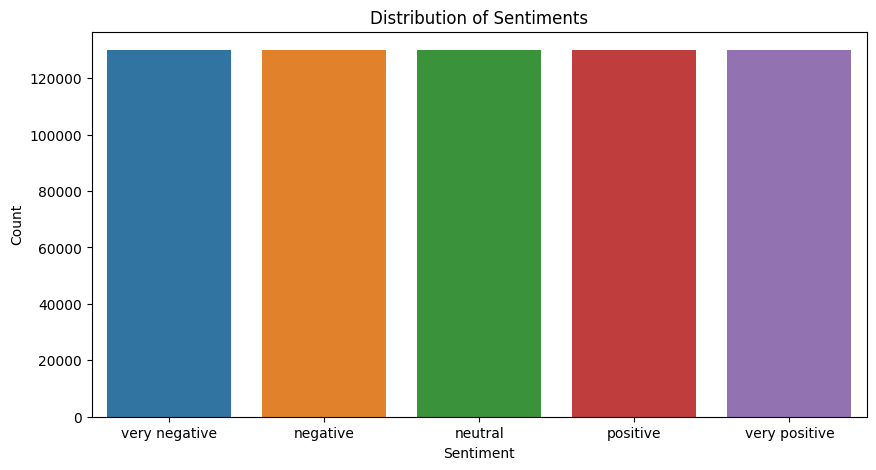

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(x="sentiment", data=df, order=sentiment_mapping.values())
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


This will give us a bar plot showing the number of reviews for each sentiment class.

Now, let's take a look at some of the reviews:


In [19]:
for sentiment in sentiment_mapping.values():
    print(f"Sample {sentiment} review:")
    sample_review = df[df["sentiment"] == sentiment]["text"].iloc[0]
    print(sample_review)
    print("\n")

Sample very negative review:
I don't know what Dr. Goldberg was like before  moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not 

Finally, let's create word clouds for the different sentiment classes. This will give us a visual representation of the most frequent words in each sentiment class:


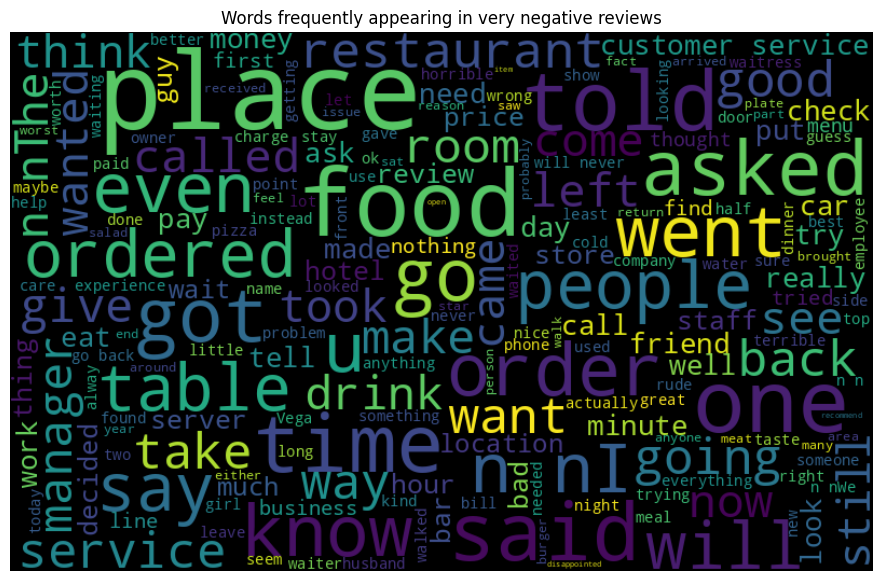

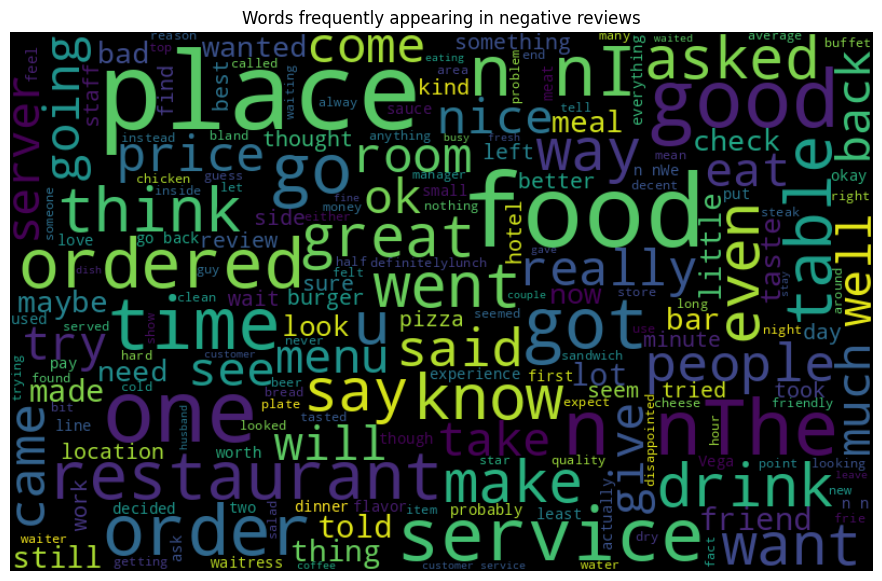

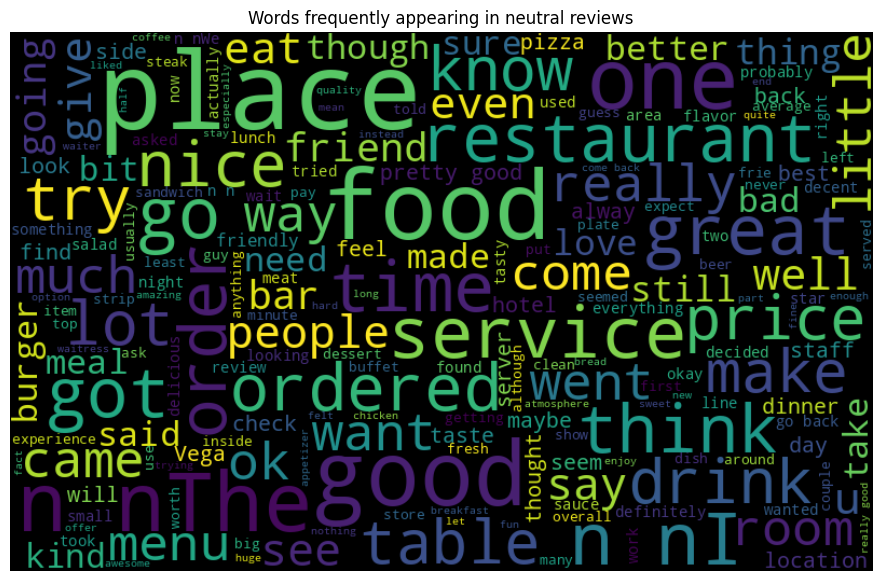

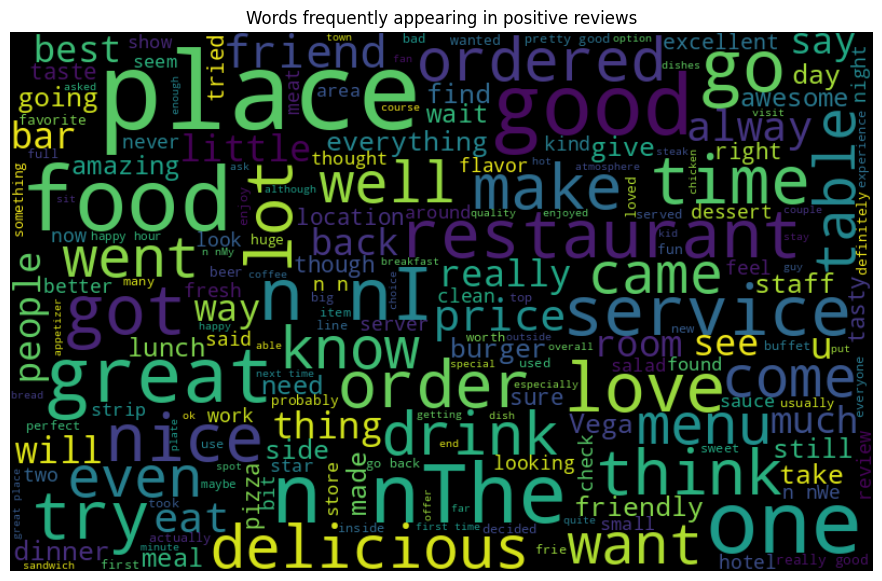

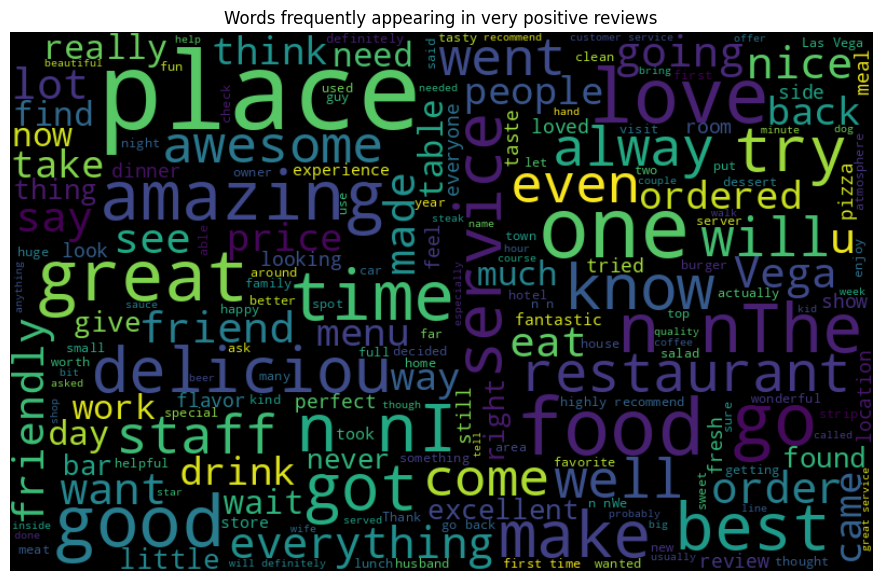

In [20]:
for sentiment in sentiment_mapping.values():
    reviews = df[df["sentiment"] == sentiment]["text"].values
    text = " ".join(reviews)

    wordcloud = WordCloud(
        width=800, height=500, random_state=42, max_font_size=100
    ).generate(text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Words frequently appearing in {sentiment} reviews")
    plt.show()

This analysis helps us understand the general patterns in our data and can guide us in the subsequent feature extraction and model training steps.


## Feature Engineering

Let's move onto feature engineering, where we'll transform our text data into features that can be used by our SVM model.

We will need to import a few additional libraries:


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

Let's define some helper functions for text preprocessing:


In [22]:
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))


def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])


def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    return " ".join([word for word in word_tokenize(text) if word not in stop_words])

We can then apply these functions to our reviews:


In [23]:
# Lowercase the text
df["text"] = df["text"].str.lower()

# Remove punctuation
df["text"] = df["text"].apply(remove_punctuation)

# Remove stopwords
df["text"] = df["text"].apply(remove_stopwords)

# Lemmatize the text
df["text"] = df["text"].apply(lemmatize_text)

We'll then use the TF-IDF vectorizer to create features from the preprocessed text. The TF-IDF vectorizer will convert our text data into a matrix of TF-IDF features.


In [24]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["text"])

For the labels, we need to convert the text labels into numerical values. We'll use `LabelEncoder` for this:


In [25]:
le = LabelEncoder()
y = le.fit_transform(df["sentiment"])

Let's split our data into training and testing sets:


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Training the Model

Let's proceed with training the SVM model using the features we've extracted. First, we need to import the required libraries:


In [27]:
from sklearn import svm
from sklearn.metrics import classification_report

We are going to use a linear SVM with a one-versus-all strategy for multi-class handling. This can be achieved using the `LinearSVC` class in scikit-learn, which automatically uses the one-vs-all strategy for multi-class classification problems.


In [28]:
# Initialize the LinearSVC model
model = svm.LinearSVC(random_state=42)

# Train the model
model.fit(X_train, y_train)

LinearSVC(random_state=42)

We now have a trained model! The next step is to evaluate the performance of our model on the testing data:


In [29]:
# Use the model to predict the test set
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

     negative       0.52      0.45      0.48     25992
      neutral       0.51      0.43      0.47     26130
     positive       0.50      0.45      0.47     26048
very negative       0.66      0.78      0.71     26100
very positive       0.62      0.74      0.68     25730

     accuracy                           0.57    130000
    macro avg       0.56      0.57      0.56    130000
 weighted avg       0.56      0.57      0.56    130000



The classification report will show the precision, recall, and F1-score of our model for each class.

Let's plot a confusion matrix to understand the performance of our model better. We'll use matplotlib and seaborn for this.


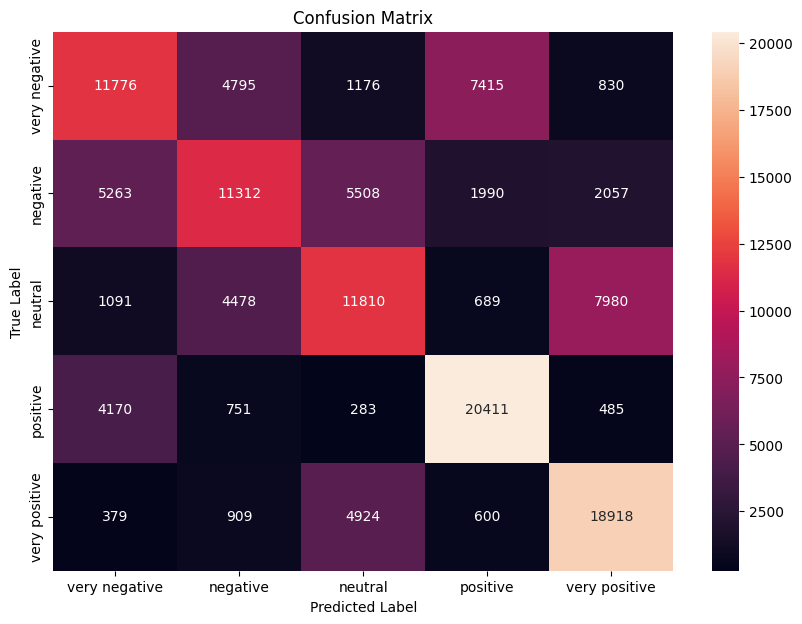

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=sentiment_mapping.values(),
    yticklabels=sentiment_mapping.values(),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This code generates a confusion matrix, which is a table layout that allows visualization of the model's performance. In this matrix, each row represents the instances of an actual class, while each column represents the instances of a predicted class. The name stems from the idea of showing where the model is "confused" — where it predicted one class when the actual class was different.

This confusion matrix will give you detailed insights into the prediction capabilities of your model, highlighting where it made most mistakes.

It's important to remember that the quality of the model can depend on many factors, such as the choice of features and the parameters of the model. You may need to go back and modify the feature extraction step or tune the parameters of the model to improve its performance.

Also, note that SVMs are more suited to binary classification tasks and can be computationally expensive for multi-class problems with large datasets. Depending on the size of your dataset and the computational resources available, you may need to consider other models such as logistic regression or deep learning.
